In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from Backtesting import stats, portfolio

In [2]:
def signal_generation(asset, stop_loss):
        
    signals = pd.DataFrame()
    signals['asset'] = asset['Close']
    signals['close'] = (asset['Open'] + asset['Close'] + asset['High'] + asset['Low'])/4
    signals['open'] = 0.0
    signals.at[signals.index[0], 'open'] = asset['Open'].iloc[0]

    for i in range(1,len(signals)):
        signals.at[signals.index[i],'open'] = (signals['open'].iloc[i-1] + signals['close'].iloc[i-1])/2
        
    temp = pd.concat([signals['open'], signals['close'], asset['Low'], asset['High']], axis=1)
    signals['high'] = temp.apply(max,axis=1)
    signals['low'] = temp.apply(min,axis=1)
    signals['signals'] = 0
    signals['positions'] = 0

    for i in range(1,len(signals)):
        
        # Long trigger
        if signals['open'].iloc[i] > signals['close'].iloc[i] and signals['open'].iloc[i] == signals['high'].iloc[i] and signals['open'].iloc[i-1] > signals['close'].iloc[i-1]:
            if np.abs(signals['open'].iloc[i]-signals['close'].iloc[i]) > np.abs(signals['open'].iloc[i-1]-signals['close'].iloc[i-1]):
                if signals['positions'].iloc[i - 1] >= stop_loss:
                    signals.at[signals.index[i], 'signals'] = 0
                else:
                    signals.at[signals.index[i], 'signals'] = 1
        
        # Short triger
        elif signals['open'].iloc[i] < signals['close'].iloc[i] and signals['open'].iloc[i] == signals['low'].iloc[i] and signals['open'].iloc[i-1] < signals['close'].iloc[i-1]:
            signals.at[signals.index[i],'signals'] = min(-signals['positions'].iloc[i-1], 0)
        
        signals['positions']=signals['signals'].cumsum()
        
    return signals

In [3]:
def plot(signals, ticker):

    # Long/short signals
    plt.figure(figsize=(11,7))
    plt.plot(signals['asset'], label=ticker, color='C0')
    plt.plot(signals['asset'][signals['signals']>0], lw=0, marker='^', markersize=7, c='g', alpha=0.6, label='LONG')
    plt.plot(signals['asset'][signals['signals']<0], lw=0, marker='v', markersize=7, c='r', alpha=0.6, label='SHORT')
    plt.legend(loc='upper left')
    plt.xlabel('Date', labelpad=15)
    plt.ylabel(ticker, labelpad=15)
    plt.title('Heikin-Ashi', pad=15)
    plt.grid(True)
    plt.show()

    # Candlesticks
    plt.figure(figsize=(11,7))

    # Default bar size
    bar_size = 40
    bar = [-bar_size, 0, bar_size]
    
    for i in range(bar_size, len(signals) - bar_size, int(2.5 * bar_size)):
        x=[signals.index[i+j] for j in bar]
        y1=[min(signals['open'].iloc[i], signals['close'].iloc[i]) * 0.99] * 3
        y2=[max(signals['open'].iloc[i], signals['close'].iloc[i]) * 1.01] * 3

        # Check if open/close is high
        if signals['high'].iloc[i] != max(signals['open'].iloc[i], signals['close'].iloc[i]):
            plt.plot([signals.index[i], signals.index[i]], [y2[0], max(signals['open'].iloc[i], signals['close'].iloc[i]) * 1.1], c='black')
    
        # Check if open/close is low
        if signals['low'].iloc[i] != min(signals['open'].iloc[i],signals['close'].iloc[i]):
            plt.plot([signals.index[i], signals.index[i]], [y1[0], min(signals['open'].iloc[i], signals['close'].iloc[i]) * 0.9], c='black')
        
        plt.fill_between(x, y1, y2, edgecolor='black', facecolor=('r' if signals['open'].iloc[i] > signals['close'].iloc[i] else 'g'))

    plt.xlabel('Date', labelpad=15)
    plt.ylabel('Price', labelpad=15)
    plt.title('Heikin-Ashi', pad=15)
    plt.grid(True)
    plt.show()

In [4]:
def HeikinAshi(ticker, start_date, end_date, capital):

    asset = yf.download(ticker, start=start_date, end=end_date, progress=False)

    # Default stop loss position of 3 longs
    signals = signal_generation(asset, 3)

    plot(signals, ticker)

    return stats(portfolio(signals, capital, 'Heikin-Ashi'), signals, start_date, end_date, capital)


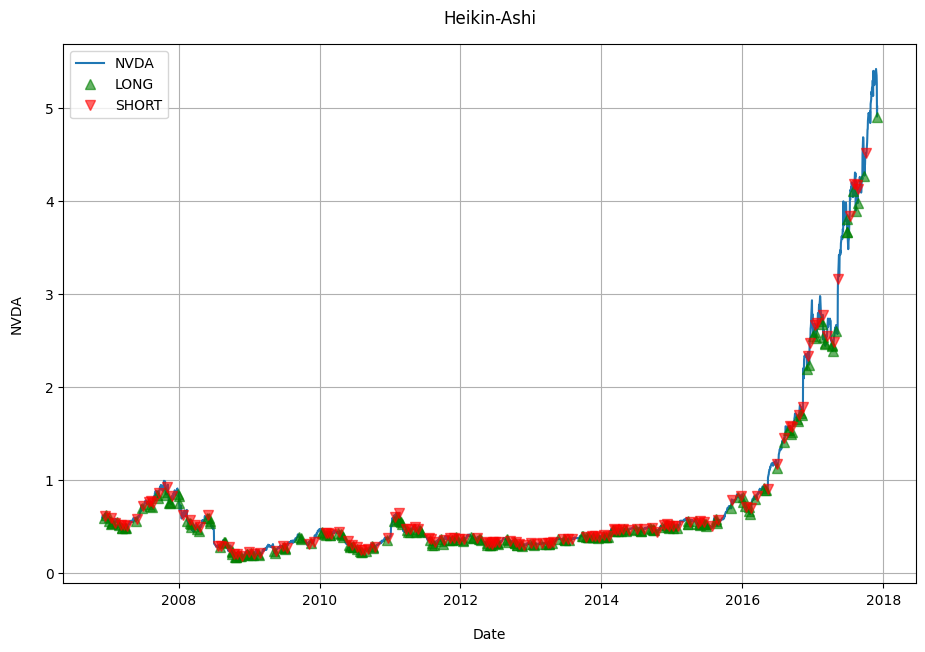

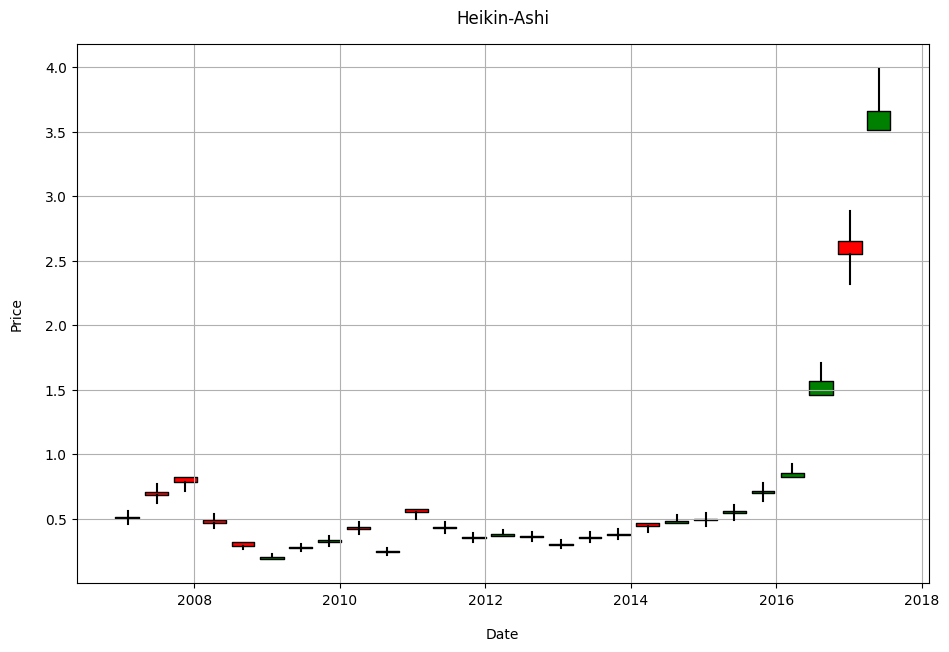

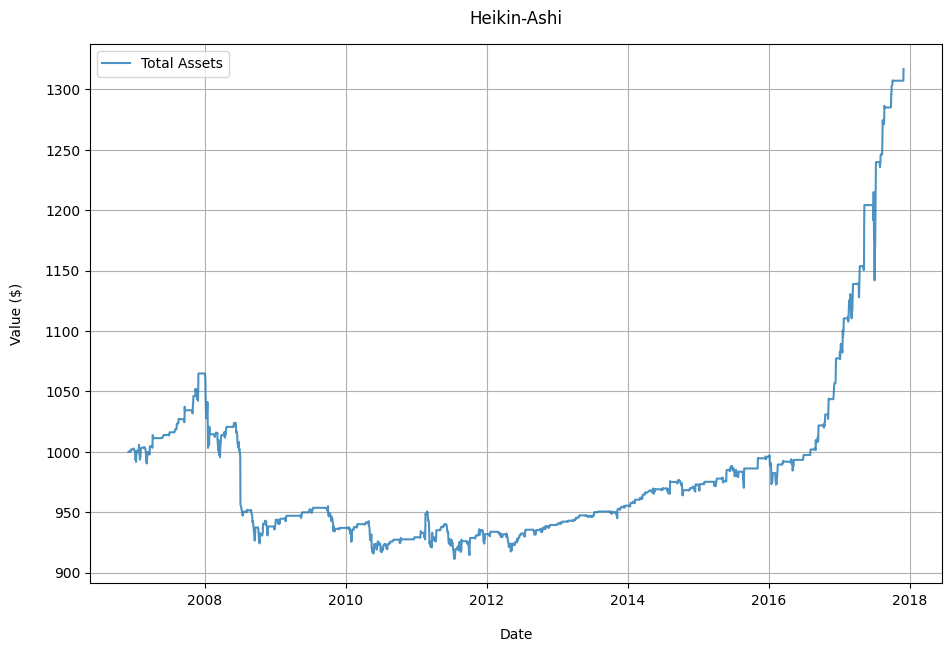

,portfolio return,benchmark return,growth rate,sharpe ratio,maximum drawdown,calmar ratio,avg trade length,profit per trade
0,0.316973,0.890278,0.000099,-0.049774,-0.144217,-0.00069,2.856061,0.800436


In [5]:
HeikinAshi('NVDA', '2006-12-01', '2017-12-01', 1000)